In [1]:
import json
import os
import math
import librosa
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.models import model_from_json

from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report,confusion_matrix
import pickle

In [2]:
genres = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']

In [3]:
def extract_features(song):
    data,sample_rate = librosa.load(song)
    result = np.array([])
    # ZCR
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally
    
    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    return result

In [4]:
import pandas as pd
df = pd.read_csv('features.csv')
print(len(df))

9790


In [5]:
X = df.iloc[:,1:-1]
y = df.iloc[:,-1]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

Defining the classifier model

In [6]:
def classifier():
    
    model=Sequential()
    model.add(Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(162,1)))
    model.add(MaxPooling1D(pool_size=2, strides = 1, padding = 'same'))

    model.add(Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=3, strides = 1, padding = 'same'))

    model.add(Conv1D(32, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides = 1, padding = 'same'))

    model.add(Flatten())
    model.add(Dense(units=16, activation='relu'))
    model.add(Dropout(0.1))

    model.add(Dense(units=10, activation='softmax'))
    model.compile(optimizer = 'sgd' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

    return model

model = classifier()
model.summary()


Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 162, 128)          512       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 162, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 162, 64)           24640     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 162, 64)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 162, 32)           6176      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 162, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5184)             

Performing Stratified K fold to find the optimal model

In [9]:
skf = StratifiedKFold(n_splits = 5, random_state = 17, shuffle = True) 

fold = 1
all_history = {}

for train_index, test_index in skf.split(np.zeros(len(df)),y):
    
    X_train,y_train= X.iloc[train_index],y.iloc[train_index]
    X_test,y_test = X.iloc[test_index], y.iloc[test_index]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    encoder = OneHotEncoder()
    y_train = encoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
    y_test = encoder.transform(np.array(y_test).reshape(-1,1)).toarray()
    
    X_train = np.expand_dims(X_train, axis=2)
    X_test = np.expand_dims(X_test, axis=2)

    model = classifier()
    print("Loop Number : ",fold)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=50)
    
    model_json = model.to_json()
    with open(f'model-{fold}.json', "w") as json_file:
        json_file.write(model_json)
    
    # serialize weights to HDF5
    model.save_weights(f'model-{fold}.h5')
    
    model_name = f'model-kfold-{fold}.h5'
            
    pickle.dump(scaler,open(f'scaler-{fold}.pkl','wb'))
    pickle.dump(encoder,open(f'encoder-{fold}.pkl','wb'))
    
    all_history[f'history-fold-{fold}'] = history
             
    fold+=1


Loop Number :  1
Train on 7832 samples, validate on 1958 samples
Epoch 1/50
7832/7832 [==============================] - 11s 1ms/step - loss: 2.2173 - accuracy: 0.2182 - val_loss: 2.0775 - val_accuracy: 0.3218
Epoch 2/50
7832/7832 [==============================] - 11s 1ms/step - loss: 1.9475 - accuracy: 0.3239 - val_loss: 1.7878 - val_accuracy: 0.3774
Epoch 3/50
7832/7832 [==============================] - 11s 1ms/step - loss: 1.7542 - accuracy: 0.3700 - val_loss: 1.6151 - val_accuracy: 0.4494
Epoch 4/50
7832/7832 [==============================] - 11s 1ms/step - loss: 1.5969 - accuracy: 0.4415 - val_loss: 1.5288 - val_accuracy: 0.4913
Epoch 5/50
7832/7832 [==============================] - 11s 1ms/step - loss: 1.5062 - accuracy: 0.4793 - val_loss: 1.4034 - val_accuracy: 0.5327
Epoch 6/50
7832/7832 [==============================] - 12s 2ms/step - loss: 1.4517 - accuracy: 0.4963 - val_loss: 1.4448 - val_accuracy: 0.5163
Epoch 7/50
7832/7832 [==============================] - 11s 1ms/s

7832/7832 [==============================] - 11s 1ms/step - loss: 1.2407 - accuracy: 0.5658 - val_loss: 1.1870 - val_accuracy: 0.5868
Epoch 12/50
7832/7832 [==============================] - 14s 2ms/step - loss: 1.2195 - accuracy: 0.5734 - val_loss: 1.1585 - val_accuracy: 0.5914
Epoch 13/50
7832/7832 [==============================] - 13s 2ms/step - loss: 1.1754 - accuracy: 0.5861 - val_loss: 1.1503 - val_accuracy: 0.5975
Epoch 14/50
7832/7832 [==============================] - 11s 1ms/step - loss: 1.1526 - accuracy: 0.5968 - val_loss: 1.1222 - val_accuracy: 0.6231
Epoch 15/50
7832/7832 [==============================] - 11s 1ms/step - loss: 1.1454 - accuracy: 0.5932 - val_loss: 1.1662 - val_accuracy: 0.5889
Epoch 16/50
7832/7832 [==============================] - 11s 1ms/step - loss: 1.1062 - accuracy: 0.6171 - val_loss: 1.0880 - val_accuracy: 0.6297
Epoch 17/50
7832/7832 [==============================] - 12s 2ms/step - loss: 1.0882 - accuracy: 0.6254 - val_loss: 1.0605 - val_accurac

Epoch 17/50
7832/7832 [==============================] - 11s 1ms/step - loss: 0.9992 - accuracy: 0.6507 - val_loss: 1.0403 - val_accuracy: 0.6394
Epoch 18/50
7832/7832 [==============================] - 11s 1ms/step - loss: 0.9933 - accuracy: 0.6507 - val_loss: 1.0257 - val_accuracy: 0.6353
Epoch 19/50
7832/7832 [==============================] - 11s 1ms/step - loss: 0.9800 - accuracy: 0.6562 - val_loss: 0.9769 - val_accuracy: 0.6655
Epoch 20/50
7832/7832 [==============================] - 12s 1ms/step - loss: 0.9596 - accuracy: 0.6622 - val_loss: 1.0127 - val_accuracy: 0.6415
Epoch 21/50
7832/7832 [==============================] - 11s 1ms/step - loss: 0.9427 - accuracy: 0.6609 - val_loss: 0.9611 - val_accuracy: 0.6706
Epoch 22/50
7832/7832 [==============================] - 11s 1ms/step - loss: 0.9202 - accuracy: 0.6736 - val_loss: 0.9324 - val_accuracy: 0.6828
Epoch 23/50
7832/7832 [==============================] - 12s 1ms/step - loss: 0.9031 - accuracy: 0.6834 - val_loss: 1.0154 -

Epoch 23/50
7832/7832 [==============================] - 11s 1ms/step - loss: 0.9516 - accuracy: 0.6712 - val_loss: 0.9224 - val_accuracy: 0.6900
Epoch 24/50
7832/7832 [==============================] - 11s 1ms/step - loss: 0.9339 - accuracy: 0.6761 - val_loss: 0.9532 - val_accuracy: 0.6777
Epoch 25/50
7832/7832 [==============================] - 11s 1ms/step - loss: 0.9258 - accuracy: 0.6765 - val_loss: 0.9734 - val_accuracy: 0.6696
Epoch 26/50
7832/7832 [==============================] - 11s 1ms/step - loss: 0.9122 - accuracy: 0.6822 - val_loss: 0.8883 - val_accuracy: 0.7074
Epoch 27/50
7832/7832 [==============================] - 11s 1ms/step - loss: 0.8927 - accuracy: 0.6878 - val_loss: 0.8693 - val_accuracy: 0.7053
Epoch 28/50
7832/7832 [==============================] - 11s 1ms/step - loss: 0.8770 - accuracy: 0.6993 - val_loss: 0.8665 - val_accuracy: 0.7063
Epoch 29/50
7832/7832 [==============================] - 11s 1ms/step - loss: 0.8694 - accuracy: 0.6999 - val_loss: 0.8772 -

Plotting accuracy and loss for all the models

In [10]:
def acc_loss(history):

    epochs = [i for i in range(50)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    test_acc = history.history['val_accuracy']
    test_loss = history.history['val_loss']

    fig.set_size_inches(15,5)
    
    ax[1].plot(epochs , train_acc , label = 'Train  Accuracy')
    ax[1].plot(epochs , test_acc , label = 'Test  Accuracy')
    ax[1].set_title('Accuracy')
    ax[1].legend(loc = 'lower right')
    ax[1].set_xlabel("Epochs")
    
    ax[0].plot(epochs , train_loss , label = 'Train Loss')
    ax[0].plot(epochs , test_loss , label = 'Test Loss')
    ax[0].set_title('Loss')
    ax[0].legend(loc = 'upper right')
    ax[0].set_xlabel("Epochs")


    
    plt.show()

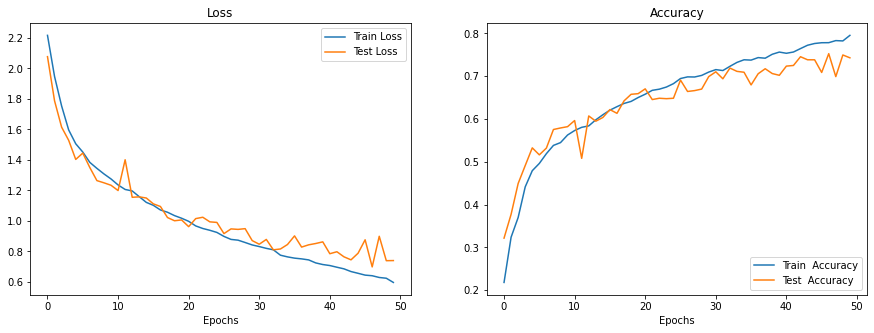

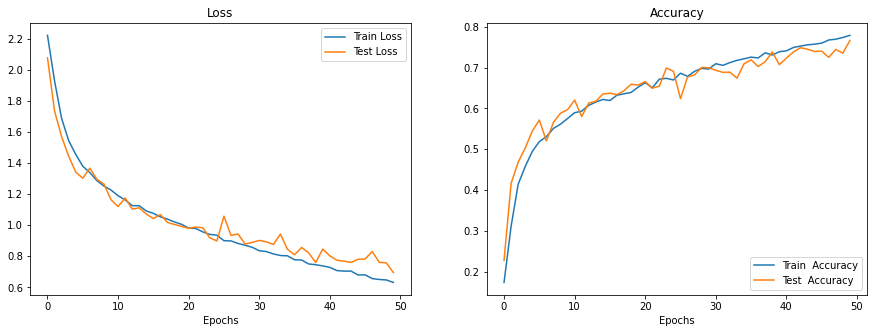

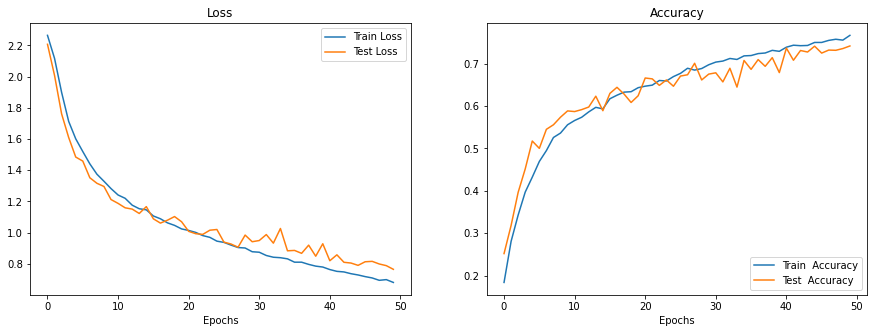

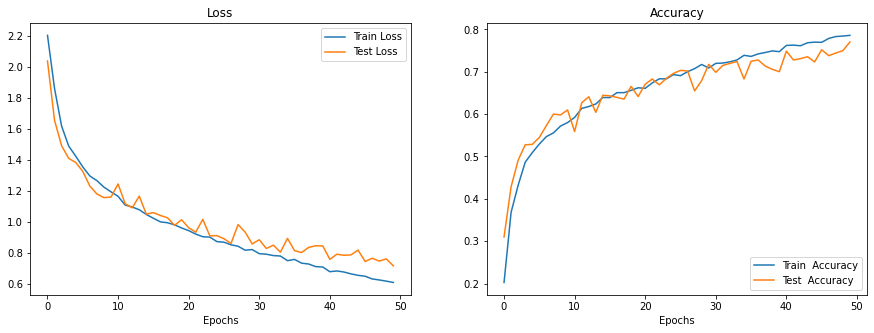

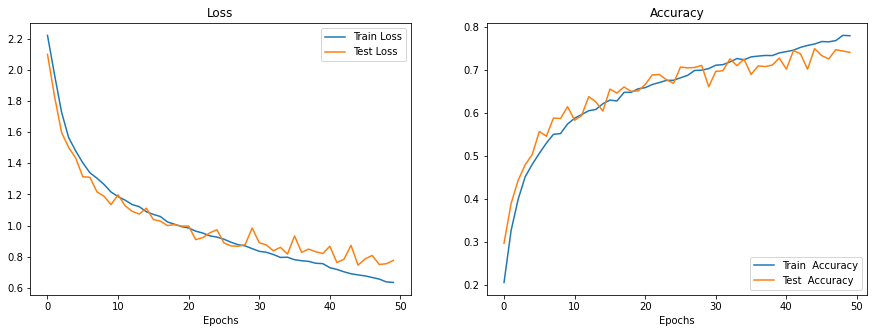

In [11]:
for i in all_history:
    acc_loss(all_history[i])

Confusion matrix and Other metrics for all the models

In [12]:
def cm(y_pred, y_test):
    import itertools
    #import numpy as np
    #import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_test, y_pred)
    labels = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
    title='Confusion matrix'
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

Model- 1
1958/1958 [==============================] - 1s 433us/step
Accuracy of test data :  86.51685118675232 %


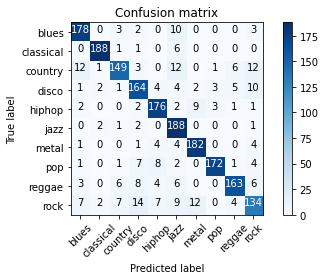

              precision    recall  f1-score   support

       blues       0.87      0.91      0.89       196
   classical       0.96      0.96      0.96       196
     country       0.88      0.76      0.82       196
       disco       0.80      0.84      0.82       196
      hiphop       0.87      0.90      0.88       196
        jazz       0.77      0.97      0.86       194
       metal       0.89      0.93      0.91       196
         pop       0.96      0.88      0.92       196
      reggae       0.91      0.83      0.87       196
        rock       0.77      0.68      0.72       196

    accuracy                           0.87      1958
   macro avg       0.87      0.87      0.86      1958
weighted avg       0.87      0.87      0.86      1958

Model- 2
1958/1958 [==============================] - 1s 374us/step
Accuracy of test data :  85.64862012863159 %


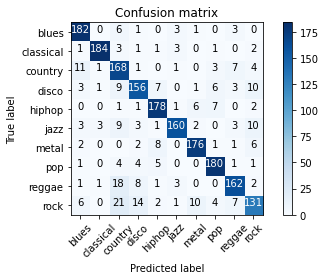

              precision    recall  f1-score   support

       blues       0.87      0.93      0.90       196
   classical       0.97      0.94      0.95       196
     country       0.70      0.86      0.77       196
       disco       0.82      0.80      0.81       196
      hiphop       0.88      0.91      0.89       196
        jazz       0.93      0.82      0.87       194
       metal       0.90      0.90      0.90       196
         pop       0.89      0.92      0.90       196
      reggae       0.87      0.83      0.85       196
        rock       0.78      0.67      0.72       196

    accuracy                           0.86      1958
   macro avg       0.86      0.86      0.86      1958
weighted avg       0.86      0.86      0.86      1958

Model- 3
1958/1958 [==============================] - 1s 428us/step
Accuracy of test data :  81.97140097618103 %


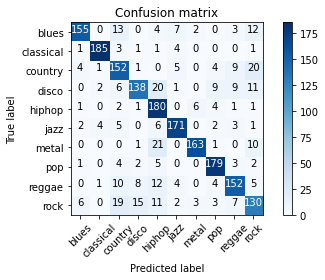

              precision    recall  f1-score   support

       blues       0.91      0.79      0.85       196
   classical       0.96      0.94      0.95       196
     country       0.71      0.78      0.74       196
       disco       0.83      0.70      0.76       196
      hiphop       0.69      0.92      0.79       196
        jazz       0.88      0.88      0.88       194
       metal       0.94      0.83      0.88       196
         pop       0.87      0.91      0.89       196
      reggae       0.81      0.78      0.79       196
        rock       0.67      0.66      0.67       196

    accuracy                           0.82      1958
   macro avg       0.83      0.82      0.82      1958
weighted avg       0.83      0.82      0.82      1958

Model- 4
1958/1958 [==============================] - 1s 293us/step
Accuracy of test data :  86.51685118675232 %


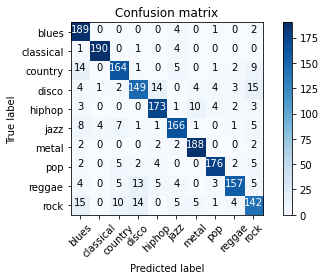

              precision    recall  f1-score   support

       blues       0.78      0.96      0.86       196
   classical       0.97      0.97      0.97       196
     country       0.85      0.84      0.84       196
       disco       0.82      0.76      0.79       196
      hiphop       0.87      0.88      0.88       196
        jazz       0.87      0.86      0.86       194
       metal       0.90      0.96      0.93       196
         pop       0.93      0.90      0.91       196
      reggae       0.92      0.80      0.86       196
        rock       0.76      0.72      0.74       196

    accuracy                           0.87      1958
   macro avg       0.87      0.87      0.86      1958
weighted avg       0.87      0.87      0.86      1958

Model- 5
1958/1958 [==============================] - 1s 732us/step
Accuracy of test data :  74.15730357170105 %


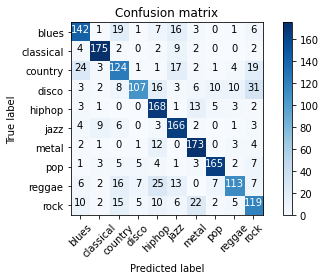

              precision    recall  f1-score   support

       blues       0.71      0.72      0.72       196
   classical       0.88      0.89      0.89       196
     country       0.64      0.63      0.63       196
       disco       0.84      0.55      0.66       196
      hiphop       0.68      0.86      0.76       196
        jazz       0.72      0.86      0.78       194
       metal       0.77      0.88      0.82       196
         pop       0.87      0.84      0.85       196
      reggae       0.80      0.58      0.67       196
        rock       0.59      0.61      0.60       196

    accuracy                           0.74      1958
   macro avg       0.75      0.74      0.74      1958
weighted avg       0.75      0.74      0.74      1958



In [13]:


for i in range(1,6):
    print("Model-",i)
    
    json_file = open(f'model-{i}.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(f"model-{i}.h5")
    loaded_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    
    print("Accuracy of test data : " , loaded_model.evaluate(X_test,y_test)[1]*100 , "%")
    
    pred_test = loaded_model.predict(X_test)
    y_pred = encoder.inverse_transform(pred_test)
    y_test_1 = encoder.inverse_transform(y_test)
    
    cm(y_pred, y_test_1)
    print(classification_report(y_test_1, y_pred))

Testing on external input 

In [16]:
test_file = "test\\pop.wav"
test= []
test.append(extract_features(test_file))
test = pd.DataFrame(test)
    
json_file = open('model-4.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model-4.h5")

scaler = pickle.load(open(f'scaler-4.pkl','rb'))
encoder = pickle.load(open(f'encoder-4.pkl','rb'))

test = scaler.transform(test)
test = np.expand_dims(test, axis=2)
label= loaded_model.predict(test)
pred = encoder.inverse_transform(label)

print(pred[0][0])

pop
